## Постановка задачи

Нужно определить, какие маршруты пользователи выбирают чаще и почему.</br>
Например:
1. Ехать 2 часа в автобусе за 100 рублей
2. Ехать 1 час на такси за 1000 рублей

Факторы выбора могут включать цену, время, удобство, привычки пользователей и другие параметры.

#### Оптимальный маршрут — это баланс между стоимостью поездки и её длительностью. Нужно рассчитать индекс оптимальности, который покажет, насколько маршрут выгоден относительно других.

## Индекс оптимальности

$C_{max}$ — самая высокая стоимость среди всех маршрутов</br>
$T_{max}$ — самое длинное время среди всех маршрутов

Где $K_i$ учитывает такие факторы, как удобство транспорта (расчитаны ниже на основании данных о пользователях)

## Расчет индекса оптимальности

Для расчета данного показателя было принято решение рассчитать, сколько в среднем стоит час рабочего времени в разбивке по городам. Данные о расчетах представлены ниже.

### Логика расчёта

Если средний человек зарабатывает S рублей в час, то:
1. 1 час времени «стоит» для него S рублей.
2. Это значит, что 1 минута времени стоит S/60 рублей.
3. Если поездка экономит T минут, её ценность можно оценить как $T \times (S/60)$ рублей.

Таким образом, оптимальность поездки можно рассчитать как:
$$\text{Оптимальность}_i = \frac{K_i}{\frac{C_i}{C_{\max}} +  (1+\frac{60}{w_T})\cdot \frac{T_i}{T_{\max}}}$$

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('rosstat_zp.xlsx')
cities = pd.read_excel('city_region.xlsx')
cities.sample(5)

,Город,Код,Регион
978,Кирсанов,68,Тамбовская Область
410,Ангарск,38,Иркутская Область
33,Избербаш,5,Дагестан Республика
249,Невинномысск,26,Ставропольский Край
979,Котовск,68,Тамбовская Область


In [13]:
df = df.rename(columns={'Unnamed: 0':'region'})
df_2024 = df.loc[:,['region',2024]]
df_2024['rub_in_hour'] = (df[2024]/160).round(2) #4 рабочих недели по 40 часов
df_2024.sample(3)

,region,2024,rub_in_hour
11,Орловская Область,55820.0,348.88
54,Оренбургская Область,63582.4,397.39
18,Москва Город,162124.1,1013.28


In [14]:
df_regions=df_2024[df_2024.region != 'Российская Федерация']
df_cities = df_2024.merge(cities, how='left', left_on='region', right_on='Регион').drop_duplicates()

In [15]:
df_cities = df_cities.fillna('default')
df_cities = df_cities.loc[:,['region',2024,'rub_in_hour','Город']].reset_index(drop=True)
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164 entries, 0 to 1163
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       1164 non-null   object 
 1   2024         1164 non-null   float64
 2   rub_in_hour  1164 non-null   float64
 3   Город        1164 non-null   object 
dtypes: float64(2), object(2)
memory usage: 36.5+ KB


In [16]:
df_cities[df_cities['Город'] == 'Самара']

,region,2024,rub_in_hour,Город
818,Самарская Область,67892.6,424.33,Самара


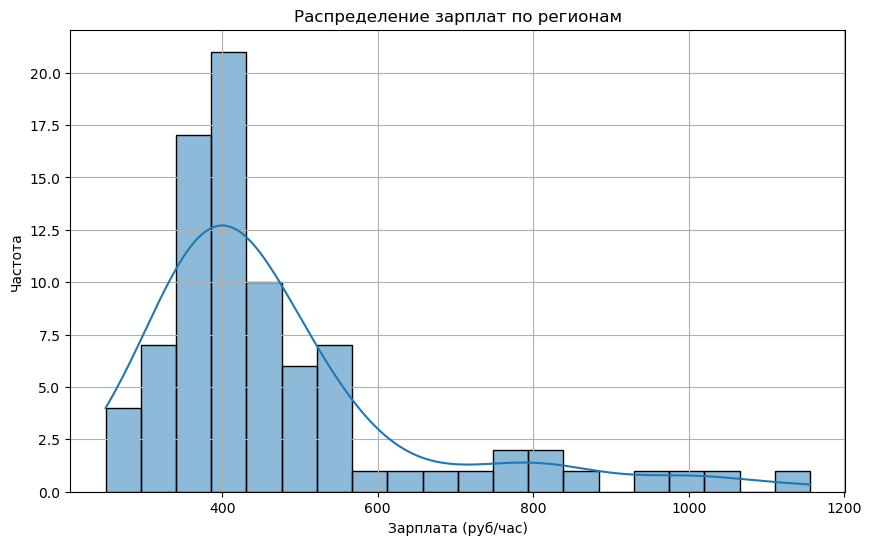

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df_regions["rub_in_hour"], bins=20, kde=True)
plt.xlabel("Зарплата (руб/час)")
plt.ylabel("Частота")
plt.title("Распределение зарплат по регионам")
plt.grid()
plt.show()

## $K_i$ для разных видов транспорта

$K_i$ — это коэффициент комфорта или привлекательности транспорта для пользователей. Он показывает, насколько предпочтителен данный вид транспорта по сравнению с другими.

Согласно результатам июньского опроса ВЦИОМ, такси входит в тройку самых популярных видов городского транспорта (38%), уступая наземному общественному транспорту (58%).</br>

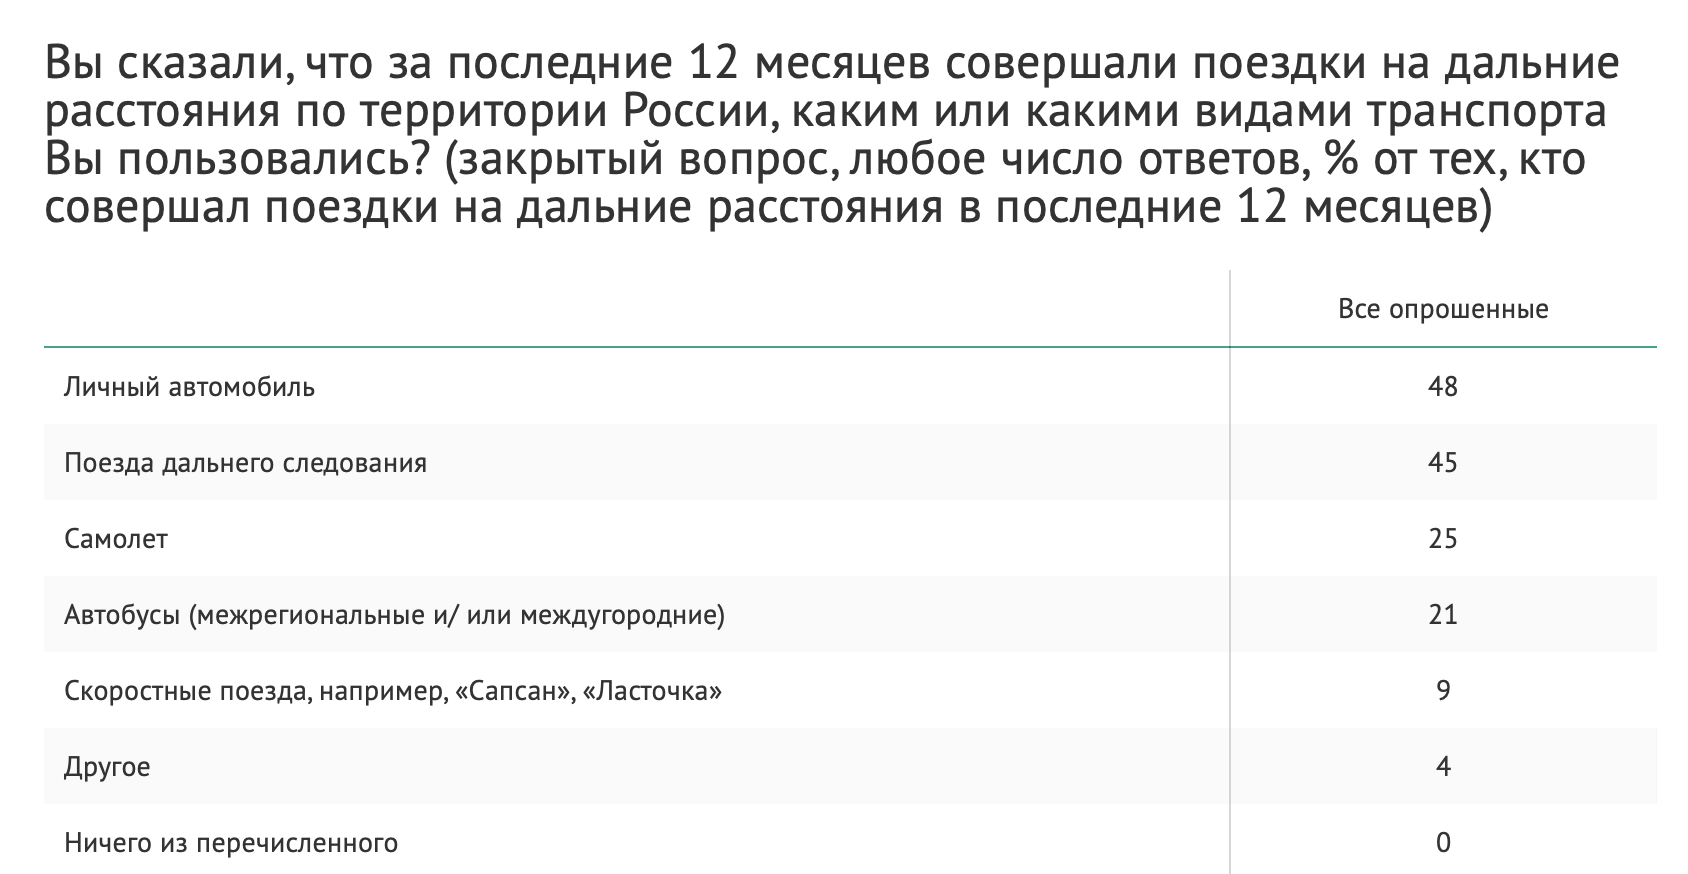

### Расчет
Мы будем считать $K_i$ на основе популярности (из соцопросов) и нормализуем данные.

Формула для расчета коэффициента комфорта:

$$K_i = 1 + \frac{\text{Доля пользователей}_i}{\sum \text{Доля пользователей по всем видам транспорта}}$$


Рассчитаем значения для междугороднего транспорта. Сумма всех значений:

$$48 + 45 + 25 + 21 + 9 = 148$$

Рассчитываем $K_i$:

$$K_{\text{автомобиль}} = 1+\frac{48}{148} \approx 1.32$$

$$K_{\text{поезд}} = 1+\frac{45}{148} \approx 1.30$$

$$K_{\text{самолёт}} = 1+\frac{25}{148} \approx 1.17$$

$$K_{\text{автобус}} = 1+\frac{21}{148} \approx 1.14$$

$$K_{\text{скоростной поезд}} = 1+\frac{9}{148} \approx 1.06$$

Рассчитаем значения для городского транспорта. Сумма всех значений:

$$38 + 58 = 96$$

Рассчитываем $K_i$:

$$K_{\text{такси}} = 1+\frac{38}{96} \approx 1.40$$

$$K_{\text{автобус}} = 1+\frac{58}{96} \approx 1.60$$

In [50]:
#city - Город пользователя
#tr_type - тип транспорта
#C_list - список всех стоимостей из выбираемых маршрутов
#T_list - список всех времен в пути из выбираемых маршрутов


def count_metric(df_cities, city, tr_type, C_max, T_max, C_i, T_i):
    K = {'plane':1.17,'bus':1.14,'train':1.3,'suburban':1.06,'taxi':1.4}

    w_T = df_cities[df_cities['Город'] == city]['rub_in_hour']
    optimality = K[tr_type] / ((C_i / C_max) +  (1+60/w_T)*(T_i / T_max))
    return optimality.iloc[0].round(3)

In [52]:
count_metric(df_cities,'Самара','plane',5000, 960, 5000, 180) #Человек из Самары летит самолетом 3 часа за 5000

0.964

In [54]:
count_metric(df_cities,'Самара','train',5000, 960, 2400, 960) #Человек из Самары едет поездом 16 часов за 2400 

0.802

Для человека из Самары где минута рабочего времени "стоит" 8 рублей переплата в 2600 не является причиной отказаться от самолета. Разница во времени составляет 780 минут или в пересчете на деньги 6240 рублей. 

In [68]:
test_cases = [
    # Москва → Санкт-Петербург (максимальное время: 10 часов)
    ('Москва', 'plane', 7000, 600, 7000, 90),   
    ('Москва', 'train', 7000, 600, 3500, 240),  
    ('Москва', 'bus', 7000, 600, 1800, 600),    

    # Москва → Екатеринбург (максимальное время: 24 часа)
    ('Москва', 'plane', 9000, 1440, 9000, 120),  
    ('Москва', 'train', 9000, 1440, 4500, 1440), 

    # Санкт-Петербург → Казань (максимальное время: 24 часа)
    ('Санкт-Петербург', 'plane', 8500, 1440, 8500, 120),  
    ('Санкт-Петербург', 'train', 8500, 1440, 5000, 1440), 

    # Екатеринбург → Новосибирск (максимальное время: 30 часов)
    ('Екатеринбург', 'plane', 10000, 1800, 10000, 180),  
    ('Екатеринбург', 'train', 10000, 1800, 6000, 1800),  

    # Казань → Самара (максимальное время: 7 часов)
    ('Казань', 'plane', 4000, 420, 4000, 60),   
    ('Казань', 'train', 4000, 420, 2000, 360),  
    ('Казань', 'bus', 4000, 420, 1500, 420),    

    # Новосибирск → Красноярск (максимальное время: 10 часов)
    ('Новосибирск', 'plane', 7000, 600, 7000, 90),   
    ('Новосибирск', 'train', 7000, 600, 3500, 600),  

    # Самара → Ростов-на-Дону (максимальное время: 18 часов)
    ('Самара', 'plane', 5500, 1080, 5500, 120),  
    ('Самара', 'train', 5500, 1080, 2800, 1080), 

    # Ростов-на-Дону → Краснодар (максимальное время: 5 часов)
    ('Ростов-на-Дону', 'train', 3500, 300, 1500, 240),  
    ('Ростов-на-Дону', 'bus', 3500, 300, 1000, 300),    

    # Челябинск → Уфа (максимальное время: 10 часов)
    ('Челябинск', 'plane', 5000, 600, 5000, 60),  
    ('Челябинск', 'train', 5000, 600, 2500, 540), 
    ('Челябинск', 'bus', 5000, 600, 1800, 600),   

    # Владивосток → Хабаровск (максимальное время: 12 часов)
    ('Владивосток', 'plane', 22000, 720, 22000, 90),   
    ('Владивосток', 'train', 22000, 720, 3200, 720),  

    # Москва → Владивосток (максимальное время: 7 дней)
    ('Москва', 'plane', 25000, 10320, 25000, 480),  
    ('Москва', 'train', 25000, 10320, 15000, 10320) 
]

# Запуск тестов
for test in test_cases:
    result = count_metric(df_cities, *test)
    print(f"{test}: {result}")

('Москва', 'plane', 7000, 600, 7000, 90): 1.01
('Москва', 'train', 7000, 600, 3500, 240): 1.407
('Москва', 'bus', 7000, 600, 1800, 600): 0.866
('Москва', 'plane', 9000, 1440, 9000, 120): 1.075
('Москва', 'train', 9000, 1440, 4500, 1440): 0.834
('Санкт-Петербург', 'plane', 8500, 1440, 8500, 120): 1.073
('Санкт-Петербург', 'train', 8500, 1440, 5000, 1440): 0.775
('Екатеринбург', 'plane', 10000, 1800, 10000, 180): 1.052
('Екатеринбург', 'train', 10000, 1800, 6000, 1800): 0.755
('Казань', 'plane', 4000, 420, 4000, 60): 1.008
('Казань', 'train', 4000, 420, 2000, 360): 0.887
('Казань', 'bus', 4000, 420, 1500, 420): 0.759
('Новосибирск', 'plane', 7000, 600, 7000, 90): 1.001
('Новосибирск', 'train', 7000, 600, 3500, 600): 0.799
('Самара', 'plane', 5500, 1080, 5500, 120): 1.038
('Самара', 'train', 5500, 1080, 2800, 1080): 0.788
('Ростов-на-Дону', 'train', 3500, 300, 1500, 240): 0.961
('Ростов-на-Дону', 'bus', 3500, 300, 1000, 300): 0.791
('Челябинск', 'plane', 5000, 600, 5000, 60): 1.051
('Челя

Формула метрики показывает баланс денежных затрат и экономии времени.</br>
-	Если метрика высокая, значит, маршрут оптимальный по времени и деньгам.</br>
-	Если метрика низкая, то либо цена не оправдывает скорость, либо время слишком долгое.

### Примеры поведения

📌 Москва → Санкт-Петербург</br>
-	Самолёт (90 минут, 7000₽, метрика высокая) → Чаще выбирают люди, ценящие время.</br>
-	Сапсан (240 минут, 3500₽, метрика средняя) → Хороший компромисс между ценой и скоростью.</br>
-	Автобус (600 минут, 1800₽, метрика низкая) → Выбирают студенты, бюджетные путешественники.</br>

📌 Москва → Владивосток</br>
-	Самолёт (8 часов, 25 000₽, высокая метрика) → Почти все выберут самолёт из-за экономии времени.</br>
-	Поезд (7 суток, 15 000₽, низкая метрика) → Поедут те, кому важна экономия денег или кто любит путешествия.</br>


### Вывод

Метрика показывает, насколько маршрут оправдывает свои затраты.
Чем выше значение, тем логичнее этот вариант с точки зрения баланса времени и денег.